In [1]:
import numpy as np
import pandas as pd
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [3]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

In [4]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [5]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [8]:
pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)

DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', length=195, freq='MS')

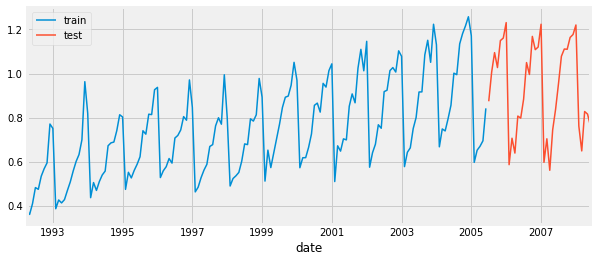

In [9]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [13]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )
# or forecaster.fit(y=data_train['y'])
forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-28 14:31:06 
Last fit date: 2022-03-28 14:31:06 
Skforecast version: 0.4.3 

In [16]:
# Predictions
# ==============================================================================
steps = 36
# or forecaster.predict(steps=steps)
predictions = forecaster.predict(steps=steps, exog=data_train[['exog_1', 'exog_2']])
predictions.head(5)

2005-07-01    0.710527
2005-08-01    0.613673
2005-09-01    0.666371
2005-10-01    0.683906
2005-11-01    0.676575
Freq: MS, Name: pred, dtype: float64

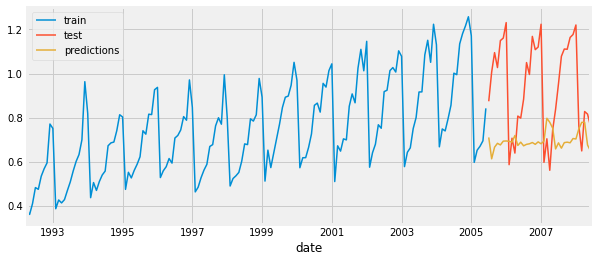

In [17]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [18]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
                )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.1083239130645553


In [19]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
                )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [10, 20]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        exog               = data_train[['exog_1', 'exog_2']],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:35<00:00, 17.73s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.007633999825779711



In [20]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.007634,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.007844,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.007919,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.007955,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.008014,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.008109,5,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.019884,10,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.020656,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.020676,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.020773,5,500


In [21]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

In [23]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_train[['exog_1', 'exog_2']])

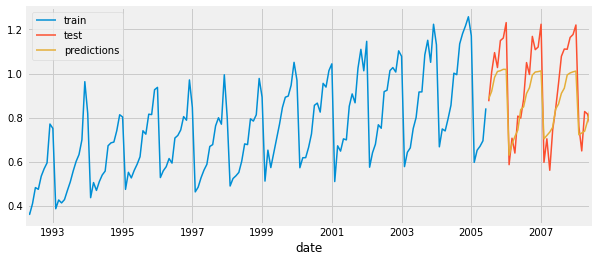

In [24]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [25]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
                )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.013495569043654097
